Basic programs I'll for sure need, more will be added as needed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline

In [2]:
import pandas_datareader.data as web
import datetime

## Section 1: Measuring reactions to FOMC announcements

There's no real way to tell how expected or unexpected an FOMC announcement is, but one common practice is to measure changes in U.S. Treasury yields in the days following announcements. There is some disagreement over how many days post-announcement to track, but this analysis will use changes in yields on FOMC days.

I first imported daily 2-year U.S. Treasury yields since January 1, 2008 via the FRED API. 

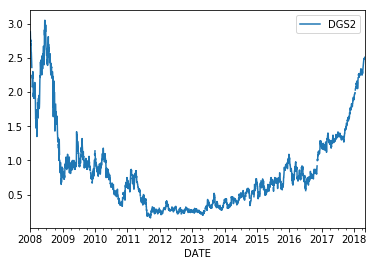

In [3]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
codes = ['DGS2'] #DGS2 = 2-Year Treasury Constant Maturity Rate, daily frequency
fred = web.DataReader(codes, 'fred', start, end)

fred.plot()

In [4]:
fred.head()

,DGS2
DATE,
2008-01-01,NaN
2008-01-02,2.88
2008-01-03,2.83
2008-01-04,2.74
2008-01-07,2.76


I want the daily change in yields, so I add that column

In [5]:
fred = fred.assign(delta = 100*fred.pct_change())
fred.head()

,DGS2,delta
DATE,,
2008-01-01,NaN,NaN
2008-01-02,2.88,NaN
2008-01-03,2.83,-1.736111
2008-01-04,2.74,-3.180212
2008-01-07,2.76,0.729927


In [6]:
fred = fred.rename(columns = {'DGS2' : '2yr_yield', 'delta' : 'daily_pct_change'})
fred.head()

,2yr_yield,daily_pct_change
DATE,,
2008-01-01,NaN,NaN
2008-01-02,2.88,NaN
2008-01-03,2.83,-1.736111
2008-01-04,2.74,-3.180212
2008-01-07,2.76,0.729927


I only want to know this data on FOMC announcement days. Unfortunately, there isn't an API for these dates, so I had to manually enter the dates from the [FOMC's website](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm) calendar into an Excel sheet (available in my GitHub repository). 

In [7]:
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas import read_csv

In [8]:
path = '/Users/simon.ilisevich/Documents/Data_Bootcamp/fomc_dates.csv'
fomc_dates = read_csv(path, index_col='Date', usecols=['Date','Announcements'])

In [9]:
fomc_dates.index.names = ['DATE']
fomc_dates.head()

,Announcements
DATE,
2008-10-08,FFR target decrease *intermeeting
2008-10-29,FFR target decrease
2008-11-25,MBS and agency debt purchase *intermeeting
2008-12-16,FFR target decrease
2009-01-28,NaN


Using the FOMC dates, I create a new dataframe that only includes yields and daily changes in yield on FOMC days

In [10]:
fomc_dates = fomc_dates.join(fred)

In [11]:
fomc_dates.head()

,Announcements,2yr_yield,daily_pct_change
DATE,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898
2008-10-29,FFR target decrease,1.58,-4.242424
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740
2008-12-16,FFR target decrease,0.65,-13.333333
2009-01-28,NaN,0.89,2.298851


In [12]:
fomc_dates.index

DatetimeIndex(['2008-10-08', '2008-10-29', '2008-11-25', '2008-12-16',
               '2009-01-28', '2009-03-18', '2009-04-29', '2009-06-24',
               '2009-08-12', '2009-09-23', '2009-11-04', '2009-12-16',
               '2010-01-27', '2010-03-16', '2010-04-28', '2010-06-23',
               '2010-08-10', '2010-09-21', '2010-11-03', '2010-12-14',
               '2011-01-26', '2011-03-15', '2011-04-27', '2011-06-22',
               '2011-08-09', '2011-09-21', '2011-11-02', '2011-12-13',
               '2012-01-25', '2012-03-13', '2012-04-25', '2012-06-20',
               '2012-08-01', '2012-09-13', '2012-10-24', '2012-12-12',
               '2013-01-30', '2013-03-20', '2013-05-01', '2013-06-19',
               '2013-09-18', '2013-10-30', '2013-12-18', '2014-01-29',
               '2014-03-19', '2014-04-30', '2014-06-18', '2014-07-30',
               '2014-09-17', '2014-10-29', '2014-12-17', '2015-01-28',
               '2015-03-18', '2015-04-29', '2015-06-17', '2015-07-29',
      

In [13]:
fred_mean = fred['daily_pct_change'].mean()
fred_std = fred['daily_pct_change'].std()

print(fred_mean)
print(fred_std)

0.13556977235635276
5.324606758338174


In [14]:
a = 2*fred_std + fred_mean
a

10.784783289032701

In [15]:
type(a)

float

Text(63,24,'MBS-purchase reduction')

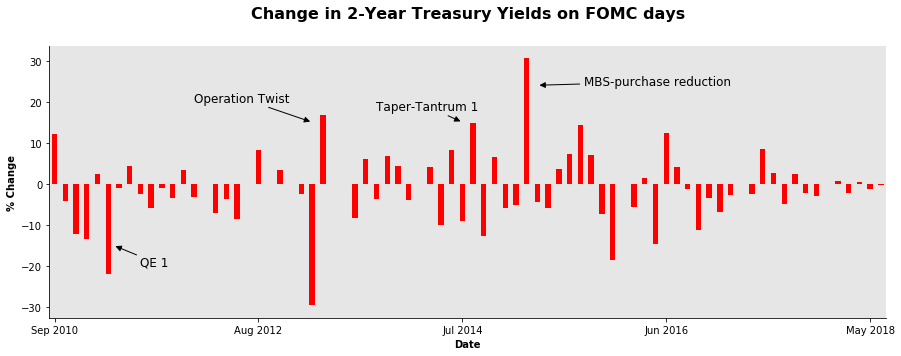

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_facecolor('0.9')

import matplotlib.ticker as ticker

clr1 = 'r'
clr2 = 'g'
clrs = [clr1 if var >= a else clr2 for var in fomc_dates['daily_pct_change']]

fomc_dates.daily_pct_change.plot(kind='bar', 
                                 ax=ax,
                                color = clrs)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title("Change in 2-Year Treasury Yields on FOMC days", fontsize=16, fontweight = "bold", y=1.08)
ax.set_ylabel("% Change", fontweight="bold") 
ax.set_xlabel("Date", fontweight='bold')

labels = ['Oct 2008', 'Sep 2010', 'Aug 2012', 'Jul 2014', 'Jun 2016', 'May 2018']
plt.gca().set_xticklabels(labels, rotation=0)

ax.xaxis.set_major_locator(ticker.MultipleLocator(19))

ax.annotate("QE 1", xy=(5.5, -15.0), xycoords="data", xytext=(8.0, -20.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>",  "color": "black"}, fontsize=12,)

ax.annotate("Operation Twist", xy=(24, 15.0), xycoords="data", xytext=(13.0, 20.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

ax.annotate("Taper-Tantrum 1", xy=(38, 15.0), xycoords="data", xytext=(30.0, 18.0), horizontalalignment="left", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

ax.annotate("MBS-purchase reduction", xy=(45, 24.0), xycoords="data", xytext=(63.0, 24.0), horizontalalignment="right", 
arrowprops={"arrowstyle": "-|>", "color": "black"},fontsize=12,)

## Section 2: Importing and Combining Chinese, Indian, and Russian market reactions

The next step is to measure changes in equity prices, exchange rates, and bond yields among three of the four largest emerging market economies. Data for this entire section came from the Stooq Index Data API. While not the easiest API to work with, it was the only API I could find that provided data for all three categories across the entire test period. 

The same importing, cleaning, and merging process is repeated for all three categories. It's explained in the equities section.

#### Equities
These are the largest equity indeces for each country from the Stooq Index Data API

China - Shanghai Composite Index

In [17]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_equities = web.DataReader('^SHC', 'stooq', start, end)
ch_equities.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-15,3181.20,3192.27,3164.79,3192.12,4.292036e+09
2018-05-14,3168.87,3183.71,3163.55,3174.03,1.290184e+10
2018-05-11,3179.84,3180.42,3162.87,3163.26,1.303172e+10
2018-05-10,3172.07,3175.71,3155.93,3174.41,1.326845e+10
2018-05-09,3160.30,3163.90,3145.66,3159.15,1.222572e+10


India - BSE SENSEX

In [18]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_equities = web.DataReader('^SNX', 'stooq', start, end)
in_equities.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-15,35580.67,35992.98,35498.32,35543.94,NaN
2018-05-14,35555.83,35642.72,35457.71,35556.71,9279750.0
2018-05-11,35301.23,35579.82,35262.67,35535.79,9210202.0
2018-05-10,35419.01,35500.02,35205.42,35246.27,8732699.0
2018-05-09,35166.24,35393.72,35138.22,35319.35,9689521.0


Russia - RTS Index

In [19]:
start = ['2008-01-01']
end = ['2018-05-04']
ru_equities = web.DataReader('^RTS', 'stooq', start, end)
ru_equities.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-15,1198.64,1198.64,1171.48,1178.76,NaN
2018-05-14,1193.53,1203.99,1185.94,1202.56,NaN
2018-05-11,1183.40,1200.21,1181.76,1193.98,2.237898e+10
2018-05-10,1154.23,1182.14,1154.00,1179.63,1.828950e+10
2018-05-08,1146.88,1146.88,1131.77,1142.13,2.169624e+10


Getting rid of unecessary columns

In [20]:
ch_equities = ch_equities.drop(ch_equities.columns[[0, 1, 2, 4]], axis=1) 
in_equities = in_equities.drop(in_equities.columns[[0, 1, 2, 4]], axis=1) 
ru_equities = ru_equities.drop(ru_equities.columns[[0, 1, 2, 4]], axis=1) 

Adding in daily percentage change

In [21]:
ch_equities = ch_equities.assign(ch_equity_change = 100*ch_equities.pct_change())
in_equities = in_equities.assign(in_equity_change = 100*in_equities.pct_change())
ru_equities = ru_equities.assign(ru_equity_change = 100*ru_equities.pct_change())

Each DataFrame has a slightly different index, so I need to create a common index among all three in order to make merging them easier

In [22]:
idx = pd.date_range('2008-01-01', '2018-05-04')

In [23]:
ch_equities.index = pd.DatetimeIndex(ch_equities.index)
ch_equities = ch_equities.reindex(idx, fill_value='NaN')

in_equities.index = pd.DatetimeIndex(in_equities.index)
in_equities = in_equities.reindex(idx, fill_value='NaN')

ru_equities.index = pd.DatetimeIndex(ru_equities.index)
ru_equities = ru_equities.reindex(idx, fill_value='NaN')

Dropping now unecessary Close prices

In [24]:
ch_equities = ch_equities.drop('Close', 1)
in_equities = in_equities.drop('Close', 1)
ru_equities = ru_equities.drop('Close', 1)

New table with emerging market equity reactions included 

In [25]:
market_response = fomc_dates.join(ch_equities, how='left', lsuffix='_left', rsuffix='_right').join(in_equities, how='left', lsuffix='_left', rsuffix='_right').join(ru_equities, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

,Announcements,2yr_yield,daily_pct_change,ch_equity_change,in_equity_change,ru_equity_change
DATE,,,,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898,0.850293,7.60374,-9.8396
2008-10-29,FFR target decrease,1.58,-4.242424,-2.48354,-7.5965,-15.1191
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740,-0.482644,-3.669,5.14401
2008-12-16,FFR target decrease,0.65,-13.333333,-0.0915612,2.69359,-1.7032
2009-01-28,NaN,0.89,2.298851,NaN,0.229421,2.95647


#### Exchange Rates

CNY/USD

In [26]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_fx = web.DataReader('CNYUSD', 'stooq', start, end)

INR/USD

In [27]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_fx = web.DataReader('INRUSD', 'stooq', start, end)

RUB/USD

In [28]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ru_fx = web.DataReader('RUBUSD', 'stooq', start, end)

In [29]:
ch_fx.head()

,Open,High,Low,Close
Date,,,,
2018-05-15,0.15774,0.15781,0.15746,0.15748
2018-05-14,0.15796,0.15810,0.15787,0.15788
2018-05-11,0.15792,0.15813,0.15758,0.15813
2018-05-10,0.15702,0.15763,0.15696,0.15759
2018-05-09,0.15704,0.15710,0.15668,0.15692


In [30]:
ch_fx = ch_fx.drop(ch_fx.columns[[0, 1, 2]], axis=1) 
in_fx = in_fx.drop(in_fx.columns[[0, 1, 2]], axis=1) 
ru_fx = ru_fx.drop(ru_fx.columns[[0, 1, 2]], axis=1) 

In [31]:
ch_fx = ch_fx.assign(ch_fx_change = 100*ch_fx.pct_change())
in_fx = in_fx.assign(in_fx_change = 100*in_fx.pct_change())
ru_fx = ru_fx.assign(ru_fx_change = 100*ru_fx.pct_change())

In [32]:
ch_fx.index = pd.DatetimeIndex(ch_fx.index)
ch_fx = ch_fx.reindex(idx, fill_value='NaN')

in_fx.index = pd.DatetimeIndex(in_fx.index)
in_fx = in_fx.reindex(idx, fill_value='NaN')

ru_fx.index = pd.DatetimeIndex(ru_fx.index)
ru_fx = ru_fx.reindex(idx, fill_value='NaN')

In [33]:
ch_fx = ch_fx.drop('Close', 1)
in_fx = in_fx.drop('Close', 1)
ru_fx = ru_fx.drop('Close', 1)

In [34]:
market_response = market_response.join(ch_fx, how='left', lsuffix='_left', rsuffix='_right').join(in_fx, how='left', lsuffix='_left', rsuffix='_right').join(ru_fx, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

,Announcements,2yr_yield,daily_pct_change,ch_equity_change,in_equity_change,ru_equity_change,ch_fx_change,in_fx_change,ru_fx_change
DATE,,,,,,,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898,0.850293,7.60374,-9.8396,4.45312,0,-0.634524
2008-10-29,FFR target decrease,1.58,-4.242424,-2.48354,-7.5965,-15.1191,4.62331,0,-1.33835
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740,-0.482644,-3.669,5.14401,2.46002,-1.20136,-0.30892
2008-12-16,FFR target decrease,0.65,-13.333333,-0.0915612,2.69359,-1.7032,-1.03809,-0.499905,-0.621887
2009-01-28,NaN,0.89,2.298851,NaN,0.229421,2.95647,NaN,0.205842,4.96925


#### Bond Prices

Chinese 10-Year

In [35]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ch_bond = web.DataReader('10CNY.B', 'stooq', start, end)

Indian 10-Year

In [36]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
in_bond = web.DataReader('10INY.B', 'stooq', start, end)

Russian 10-Year

In [37]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2018, 5, 4)
ru_bond = web.DataReader('10RUY.B', 'stooq', start, end)

In [38]:
ru_bond.head()

,Open,High,Low,Close
Date,,,,
2018-05-15,7.32,7.37,7.31,7.36
2018-05-14,7.32,7.36,7.31,7.32
2018-05-11,7.35,7.38,7.29,7.31
2018-05-10,7.38,7.42,7.34,7.35
2018-05-09,7.40,7.42,7.38,7.38


In [39]:
ch_bond = ch_bond.drop(ch_bond.columns[[0, 1, 2]], axis=1) 
in_bond = in_bond.drop(in_bond.columns[[0, 1, 2]], axis=1) 
ru_bond = ru_bond.drop(ru_bond.columns[[0, 1, 2]], axis=1) 

In [40]:
ch_bond = ch_bond.assign(ch_bond_change = 100*ch_bond.pct_change())
in_bond = in_bond.assign(in_bond_change = 100*in_bond.pct_change())
ru_bond = ru_bond.assign(ru_bond_change = 100*ru_bond.pct_change())

In [41]:
ch_bond.index = pd.DatetimeIndex(ch_bond.index)
ch_bond = ch_bond.reindex(idx, fill_value='NaN')

in_bond.index = pd.DatetimeIndex(in_bond.index)
in_bond = in_bond.reindex(idx, fill_value='NaN')

ru_bond.index = pd.DatetimeIndex(ru_bond.index)
ru_bond = ru_bond.reindex(idx, fill_value='NaN')

In [42]:
ch_bond = ch_bond.drop('Close', 1)
in_bond = in_bond.drop('Close', 1)
ru_bond = ru_bond.drop('Close', 1)

In [43]:
market_response = market_response.join(ch_bond, how='left', lsuffix='_left', rsuffix='_right').join(in_bond, how='left', lsuffix='_left', rsuffix='_right').join(ru_bond, how='left', lsuffix='_left', rsuffix='_right')
market_response.head()

,Announcements,2yr_yield,daily_pct_change,ch_equity_change,in_equity_change,ru_equity_change,ch_fx_change,in_fx_change,ru_fx_change,ch_bond_change,in_bond_change,ru_bond_change
DATE,,,,,,,,,,,,
2008-10-08,FFR target decrease *intermeeting,1.65,12.244898,0.850293,7.60374,-9.8396,4.45312,0,-0.634524,10.6061,3.59758,NaN
2008-10-29,FFR target decrease,1.58,-4.242424,-2.48354,-7.5965,-15.1191,4.62331,0,-1.33835,2.2508,1.03342,NaN
2008-11-25,MBS and agency debt purchase *intermeeting,1.15,-12.213740,-0.482644,-3.669,5.14401,2.46002,-1.20136,-0.30892,-1.88679,1.26511,NaN
2008-12-16,FFR target decrease,0.65,-13.333333,-0.0915612,2.69359,-1.7032,-1.03809,-0.499905,-0.621887,3.16901,2.55754,NaN
2009-01-28,NaN,0.89,2.298851,NaN,0.229421,2.95647,NaN,0.205842,4.96925,NaN,-2.59488,NaN


In [44]:
equity_response = market_response[['ch_equity_change', 'in_equity_change', 'ru_equity_change']].copy()
equity_response.head()

,ch_equity_change,in_equity_change,ru_equity_change
DATE,,,
2008-10-08,0.850293,7.60374,-9.8396
2008-10-29,-2.48354,-7.5965,-15.1191
2008-11-25,-0.482644,-3.669,5.14401
2008-12-16,-0.0915612,2.69359,-1.7032
2009-01-28,NaN,0.229421,2.95647


In [45]:
fx_response = market_response[['ch_fx_change', 'in_fx_change', 'ru_fx_change']].copy()
fx_response.head()

,ch_fx_change,in_fx_change,ru_fx_change
DATE,,,
2008-10-08,4.45312,0,-0.634524
2008-10-29,4.62331,0,-1.33835
2008-11-25,2.46002,-1.20136,-0.30892
2008-12-16,-1.03809,-0.499905,-0.621887
2009-01-28,NaN,0.205842,4.96925


In [46]:
bond_response = market_response[['ch_bond_change', 'in_bond_change', 'ru_bond_change']].copy()
bond_response.head()

,ch_bond_change,in_bond_change,ru_bond_change
DATE,,,
2008-10-08,10.6061,3.59758,NaN
2008-10-29,2.2508,1.03342,NaN
2008-11-25,-1.88679,1.26511,NaN
2008-12-16,3.16901,2.55754,NaN
2009-01-28,NaN,-2.59488,NaN


## Section 3: Summarizing market reactions

As I was creating my first graph I came across an error in the first line of my for loop stating that 'z' (a list of each column from the "market_response" dataframe to be graphed) couldn't be read because it was a list of objects, and needed to be in a number form. The next few lines fixed that.

In [47]:
z = ['ch_equity_change','ch_fx_change', 'ch_bond_change', 'in_equity_change', 'in_fx_change', 'in_bond_change', 'ru_equity_change', 'ru_fx_change', 'ru_bond_change']

In [48]:
for var in z:
    market_response[var] = pd.to_numeric(market_response[var], errors = 'force')

In [49]:
market_response.dtypes

Announcements        object
2yr_yield           float64
daily_pct_change    float64
ch_equity_change    float64
in_equity_change    float64
ru_equity_change    float64
ch_fx_change        float64
in_fx_change        float64
ru_fx_change        float64
ch_bond_change      float64
in_bond_change      float64
ru_bond_change      float64
dtype: object

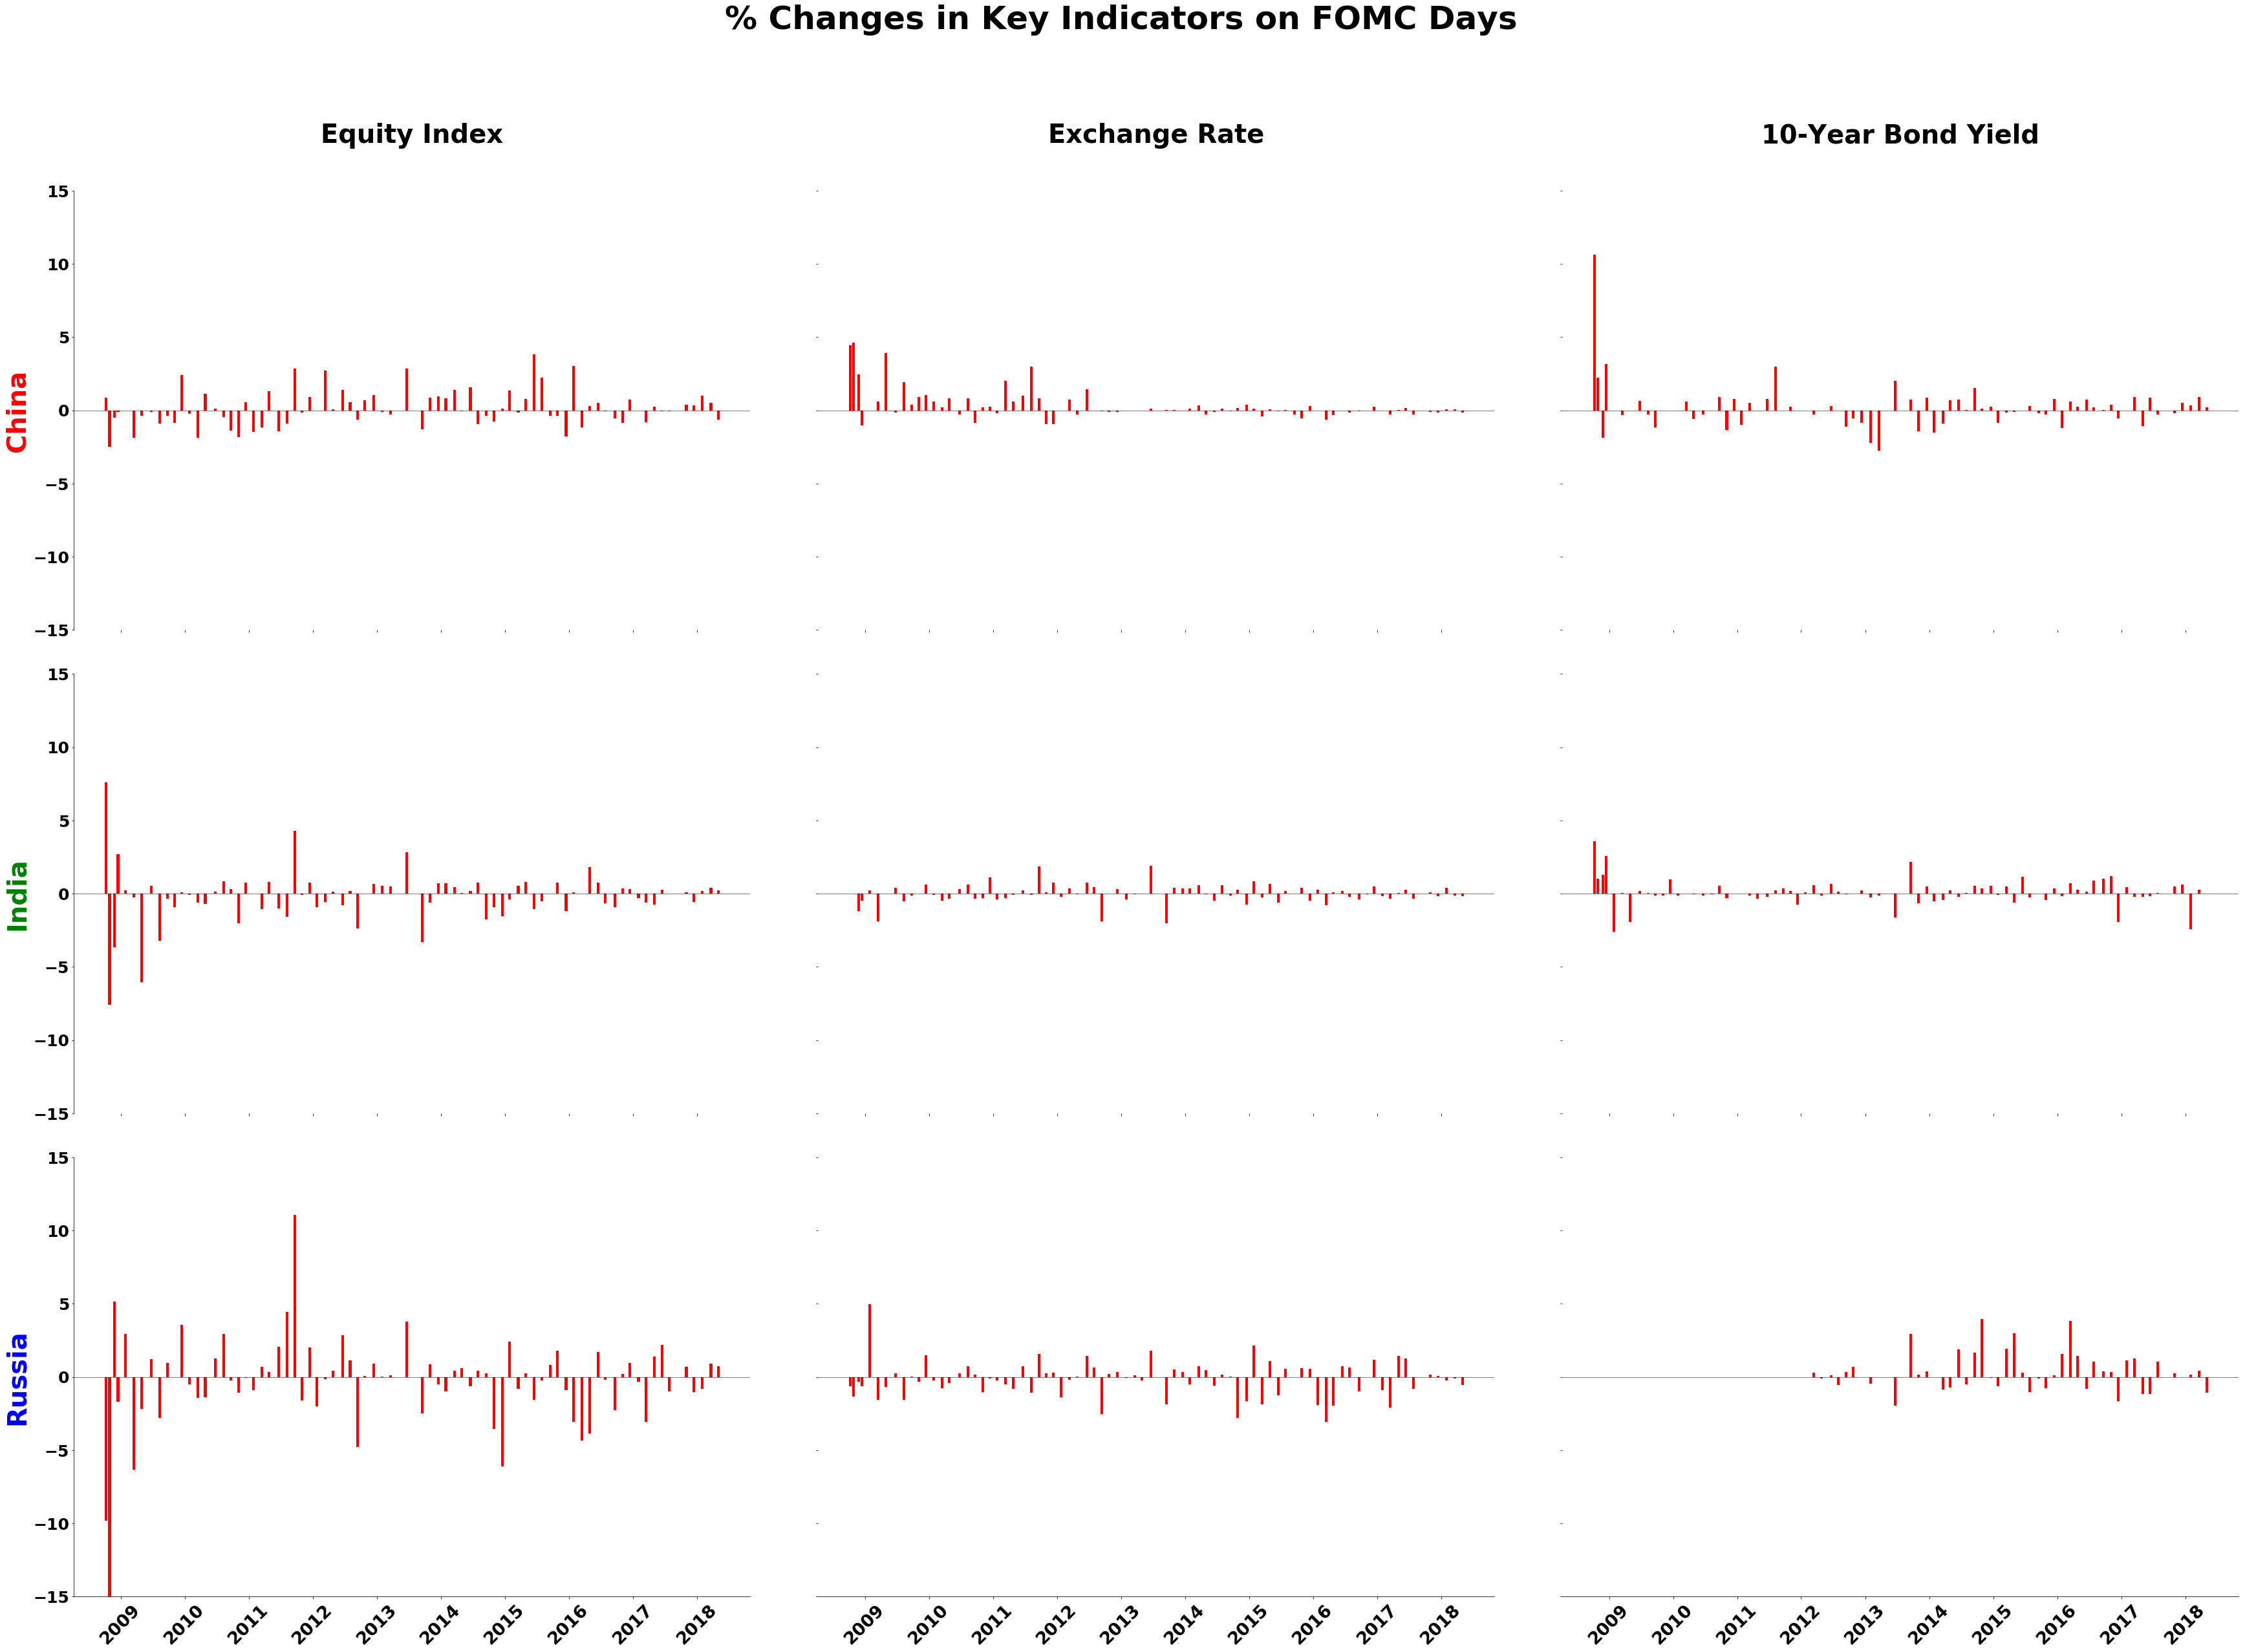

In [124]:
from pylab import *
import matplotlib.colors as cl

fig, ax = plt.subplots(nrows = 3, ncols = 3, sharex = 'col', sharey = 'row', figsize = (60,40))

ax = ax.ravel()

count = 0

colors = ['red' if count < 3 else 'blue']

for graph in ax:
    
    #basic graph
    graph.bar(market_response.index, market_response[z[count]], width=15, color = colors) 


    #adjusting xticks
    for tick in graph.xaxis.get_major_ticks():
        tick.label1.set_fontsize(27)
        tick.label1.set_fontweight('bold')
        tick.label.set_rotation(45)
        
    for tick in graph.yaxis.get_major_ticks():
        tick.label1.set_fontsize(25)
        tick.label1.set_fontweight('bold')
        
    graph.axhline(y=0, color='k', linewidth=0.5)
    
    graph.set_ylim(-15,15)
    
    #spines
    graph.spines["right"].set_visible(False) 
    graph.spines["top"].set_visible(False)
   
    if count < 6:
        graph.spines['bottom'].set_visible(False)  
        
    key_values = [0, 3, 6]
    
    for x in key_values:
        if count is x:
             graph.spines['left'].set_visible(True)
        else:
            graph.spines['left'].set_visible(False)
    
    if count is 0:
        graph.spines['left'].set_visible(True)
    
    if count is 3:
        graph.spines['left'].set_visible(True)
    
    #row labels
    if count is 0:
        graph.set_ylabel('China', fontsize=40, color='r', fontweight='bold')
    if count is 3:
        graph.set_ylabel('India', fontsize=40, color = 'g', fontweight='bold')
    if count is 6:
        graph.set_ylabel('Russia', fontsize=40, color = 'b', fontweight='bold')
    
    count = count + 1
        
ax[0].set_title('Equity Index', fontsize=40, y = 1.1, fontweight = "bold")
ax[1].set_title('Exchange Rate', fontsize=40, y = 1.1, fontweight = "bold")
ax[2].set_title('10-Year Bond Yield', fontsize=40, y = 1.1, fontweight = "bold")

fig.suptitle("% Changes in Key Indicators on FOMC Days", fontsize = 50, fontweight = "bold", y=0.98) 

fig.subplots_adjust(hspace=0.1, wspace=0.1)


Now that we have changes in asset prices in each country, we can collapse them by indicator and compute their average.

In [157]:
for var in equity_response:
    equity_response[var] = pd.to_numeric(equity_response[var], errors = 'force')
for var in fx_response:
    fx_response[var] = pd.to_numeric(fx_response[var], errors = 'force')
for var in bond_response:
    bond_response[var] = pd.to_numeric(bond_response[var], errors = 'force')

In [93]:
equity_response['avg'] = equity_response.mean(axis=1)
fx_response['avg'] = fx_response.mean(axis=1)
bond_response['avg'] = bond_response.mean(axis=1)

Text(0.5,0.9,'% Changes in Key Indicators vs. 2-Year-Treasury Yields')

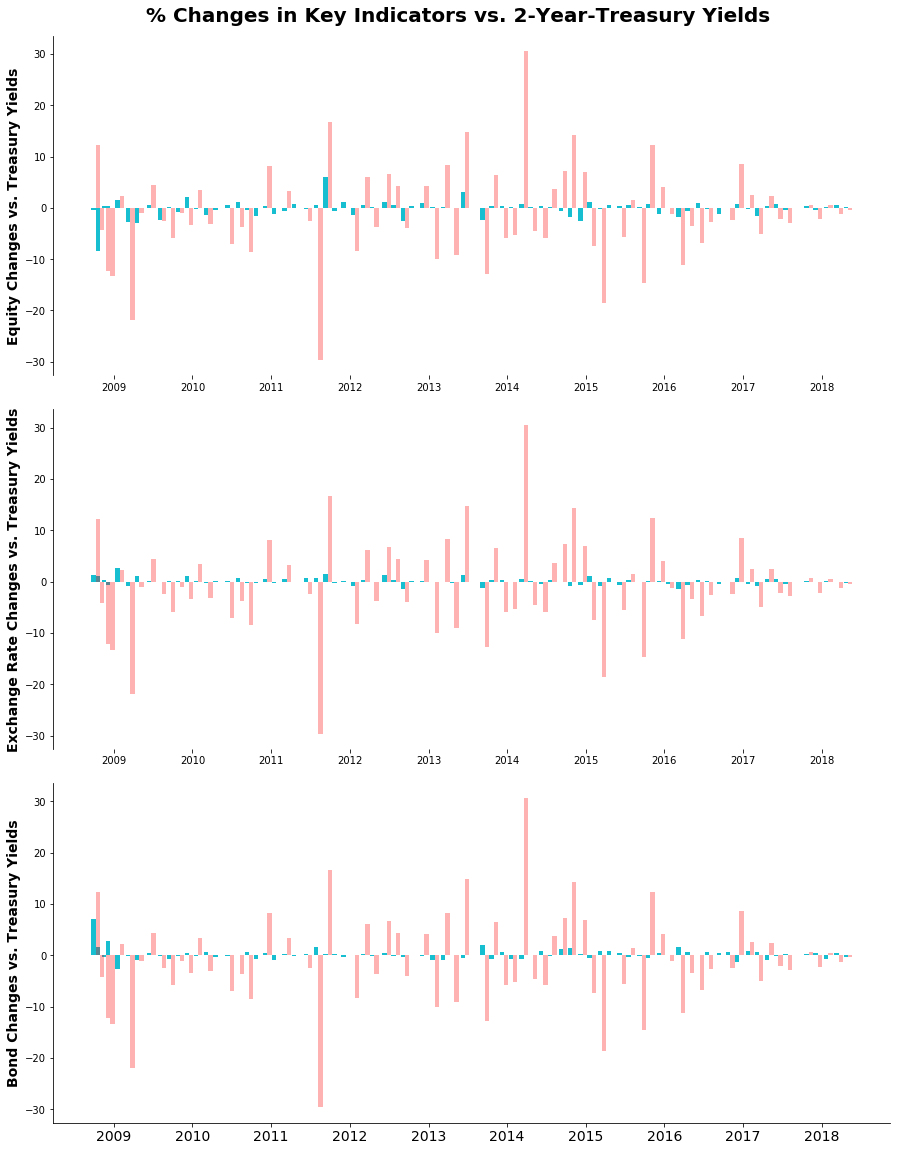

In [156]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,20))

ax[0].bar(equity_response.index, equity_response['avg'], width=-20, align='edge', color='C9', alpha=1)
ax[0].bar(equity_response.index, fomc_dates['daily_pct_change'], width=+20, align='edge', color='red', alpha=0.3)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_ylabel('Equity Changes vs. Treasury Yields', fontsize=14, fontweight='bold')


ax[1].bar(fx_response.index, fx_response['avg'], width=-20, align='edge', color='C9')
ax[1].bar(fx_response.index, fomc_dates['daily_pct_change'], width=+20, align='edge', color='red', alpha=0.3)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_ylabel('Exchange Rate Changes vs. Treasury Yields', fontsize=14, fontweight='bold')

ax[2].bar(bond_response.index, bond_response['avg'], width=-20, align='edge', color='C9')
ax[2].bar(bond_response.index, fomc_dates['daily_pct_change'], width=+20, align='edge', color='red', alpha=0.3)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_ylabel('Bond Changes vs. Treasury Yields', fontsize=14, fontweight='bold')

for tick in ax[2].xaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    
fig.subplots_adjust(hspace=0.1)

fig.suptitle("% Changes in Key Indicators vs. 2-Year-Treasury Yields", fontsize = 20, fontweight = "bold", y=0.9) 


These final graphs suggest there isn't a strong correlation between the expectedness of FOMC policy announcements and emerging market financial conditions, at least under the assumption that sudden changes in U.S. treasury yields signify surprise. That being said, there are a number of obvious reasons to question this conclusion, given the limit of the study. 

Ways to improve/expand on this study are:
* Most significantly would be to incorporate more emerging countries, especially since China, India, and Brazil are three of the four largest emerging market economies, and as such have more developed financial systems that make them less vulnerable to schocks than other smaller economies
* Compensating for noise and/or country-specific factors that inevitably affect the data
* Using a different metric for determing "surprise" to FOMC announements, especially as the Great Recesion becomes further away and unconventional policy becomes the norm